<a href="https://colab.research.google.com/github/cjer/covid/blob/master/israel_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('whitegrid')

In [94]:
niv = pd.read_csv('data/corona_tested_individuals_ver_0032.csv.gz', 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-06-22,1,0,0,0,0,שלילי,No,זכר,Abroad
1,2020-06-22,0,0,0,0,0,שלילי,No,נקבה,Other
2,2020-06-22,0,0,0,0,0,שלילי,No,זכר,Other
3,2020-06-22,0,0,0,0,0,שלילי,No,נקבה,Other
4,2020-06-22,0,0,0,0,0,שלילי,No,זכר,Other


In [95]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [96]:
bdi = pd.read_csv('data/corona_lab_tests_ver_0024.csv.gz', encoding='utf-8', parse_dates=[0,1])

In [97]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [98]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
1,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
2,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
3,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
4,2020-03-11,2020-03-11,שלילי,2,Yes,NaT


In [99]:
bdi.shape

(860313, 6)

In [100]:
bdi.corona_result.value_counts()

שלילי               804550
חיובי                42495
לא בוצע/פסול 999     10118
חיובי גבולי           2157
בעבודה                 597
לא ודאי                396
Name: corona_result, dtype: int64

In [101]:
niv.corona_result.value_counts()

שלילי    608182
חיובי     19409
אחר        7173
Name: corona_result, dtype: int64

In [102]:
niv.test_indication.value_counts()

Other                     593463
Abroad                     27232
Contact with confirmed     14069
Name: test_indication, dtype: int64

In [103]:
niv.age_60_and_above.value_counts()

No     158330
Yes     32505
Name: age_60_and_above, dtype: int64

In [104]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [105]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [106]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [107]:
rec = pd.read_csv('data/corona_recovered_ver_0023.csv.gz', encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,NaN,Abroad
1,22,9,30-39,NaN,Contact with confirmed
2,26,9,30-39,NaN,Contact with confirmed
3,28,9,30-39,NaN,Abroad
4,23,9,20-29,NaN,Contact with confirmed


In [108]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,7,1,15,6.857143,6.0,14
1,3,7163,2,76,15.972218,16.0,21489
2,4,3009,2,98,20.368229,20.0,12036
3,5,2135,4,76,23.997658,24.0,10675
4,6,1351,6,69,27.219837,27.0,8106
5,7,867,8,63,30.264129,30.0,6069
6,8,514,3,68,32.922179,32.5,4112
7,9,313,2,78,35.530351,35.0,2817
8,10,524,5,100,40.486641,40.0,5240


In [139]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(15).index]

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
15659,100,10+,60+,NaN,Contact with confirmed
7843,98,4,40-49,NaN,Other
6971,83,4,20-29,NaN,Other
272,78,9,60+,NaN,Contact with confirmed
15422,78,10+,0-19,NaN,Other
15614,78,10+,60+,NaN,Other
3280,76,5,0-19,NaN,Contact with confirmed
12525,76,3,40-49,NaN,Other
9383,74,3,NaN,NaN,NaN
15452,73,10+,0-19,NaN,Contact with confirmed


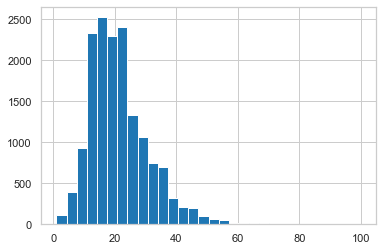

In [132]:
rec.days_between_pos_and_neg.hist(bins=30)

In [109]:
iso = pd.read_csv('data/corona_isolation_per_day_ver_0024.csv.gz',
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-06-21,13664,8690,2373,392
1,2020-06-20,12037,8805,1415,261
2,2020-06-19,11392,8932,1760,826
3,2020-06-18,11728,9163,1622,521
4,2020-06-17,11252,9128,1421,463


In [110]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [111]:
niv.age_60_and_above.value_counts()

No     158330
Yes     32505
Name: age_60_and_above, dtype: int64

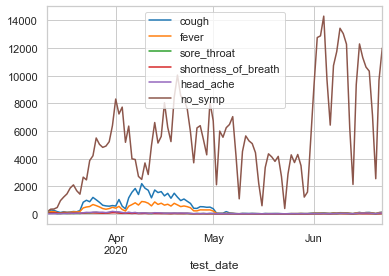

In [112]:
niv.groupby('test_date')[symptom_cols].sum().plot()

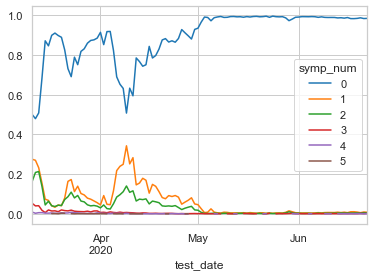

In [113]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

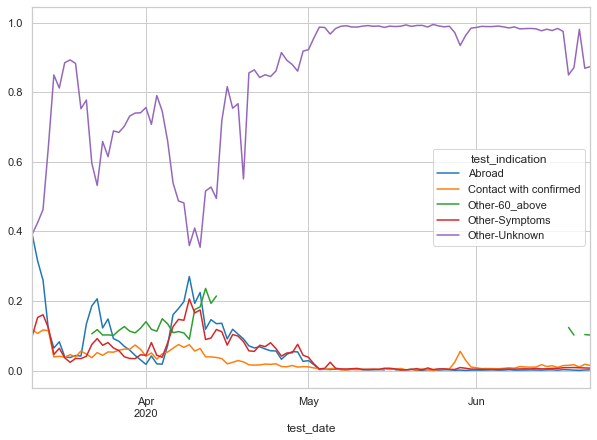

In [114]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

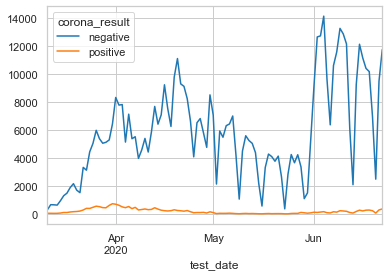

In [115]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [116]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

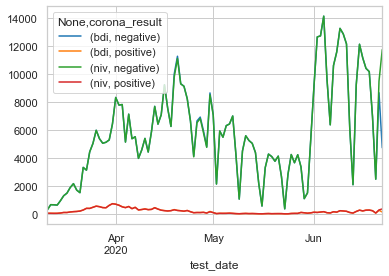

In [117]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

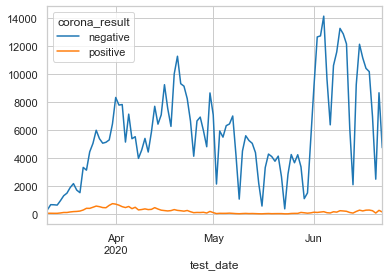

In [118]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [119]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,2,3
2020-03-12,21,7
2020-03-13,21,2
2020-03-14,24,1
2020-03-15,70,47
...,...,...
2020-06-18,4486,132
2020-06-19,2845,128
2020-06-20,776,25


In [120]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-08,28.0,NaN,4200.0,18.0,NaN
2020-05-09,31.0,NaN,1057.0,9.0,NaN
2020-05-12,46.0,NaN,5250.0,19.0,NaN
2020-05-14,57.0,1.0,4380.0,16.0,NaN
2020-05-15,28.0,NaN,2184.0,7.0,NaN
2020-05-16,25.0,NaN,559.0,4.0,NaN
2020-05-17,58.0,NaN,3314.0,15.0,NaN
2020-05-19,32.0,NaN,4104.0,12.0,NaN
2020-05-20,42.0,NaN,3768.0,16.0,NaN


In [121]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-06-18,49.0,NaN,10185.0,272.0,NaN
2020-06-19,39.0,NaN,6968.0,226.0,NaN
2020-06-20,34.0,NaN,2483.0,57.0,NaN
2020-06-21,50.0,NaN,8670.0,251.0,NaN
2020-06-22,37.0,NaN,4732.0,134.0,NaN


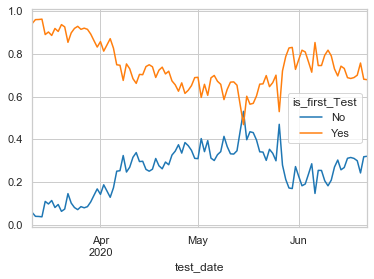

In [122]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

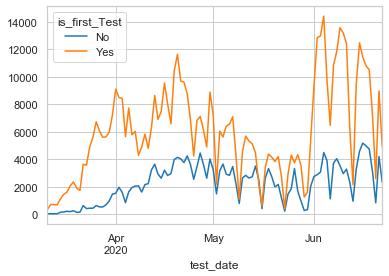

In [123]:
ti.plot()

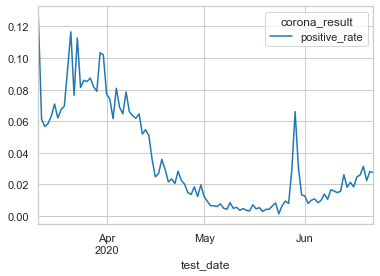

In [124]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [125]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-06-18,4737,10506
2020-06-19,3096,7233
2020-06-20,825,2574
2020-06-21,4193,8971
2020-06-22,2314,4903


In [126]:
ti.Yes.sum() + ti.No.sum()

860313

In [127]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [128]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']])

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [129]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'מונשמים': 'resp'}
hos = (pd.read_csv('data/corona_hospitalization_ver_0013.csv.gz', encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,חולים בינוני,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,78,35.9,48.0,18.2,15,33.3,68.0,18.2,70,...,46.0,16.9,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
1,2020-03-12,100,39.0,50.0,18.6,15,33.3,68.0,18.2,92,...,48.0,17.8,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
2,2020-03-13,120,39.2,49.0,18.4,15,33.3,68.0,18.2,109,...,47.0,17.4,<15,50.0,64.0,17.3,15,42.9,71.0,17.7
3,2020-03-14,159,41.5,47.0,18.6,15,25.0,76.0,12.8,149,...,45.0,17.5,<15,50.0,64.0,17.3,15,33.3,79.0,11.4
4,2020-03-15,198,44.9,46.0,18.8,15,33.3,77.0,10.3,183,...,44.0,17.5,<15,50.0,58.0,14.9,15,44.4,80.0,9.7


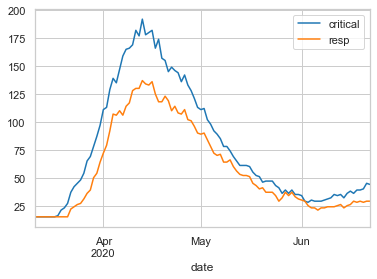

In [130]:
(hos[['date', 'critical', 'resp']].set_index('date').plot())